In [36]:
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.filters import gabor
from skimage.feature import hog
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import tqdm.auto as tqdm
import time

In [310]:
def trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [311]:
def total_params(model):
    return sum(p.numel() for p in model.parameters())

In [296]:
class FaceDataset(data.Dataset):
    def __init__(self, path):
        data = torch.tensor(pd.read_csv(path, header=None).values)
        y, X = data[:,0], data[:,1:]
        y = y.squeeze()
        self.X = X.float()
        self.y = y.long()
    
    def to(self, device):
        self.X = self.X.to(device)
        self.y = self.y.to(device)
        return self
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [215]:
class NN(nn.Module):
    def __init__(self, activ=F.sigmoid, input_dim=2304):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.fc2 = nn.Linear(100, 7)
        self.output = nn.Softmax(dim=1)
        self.activ = activ
        self.cross_entropy = nn.CrossEntropyLoss()
    
    def forward(self, X):
        X = self.activ(self.fc1(X))
        X = self.fc2(X)
        return self.output(X)
    
    def predict(self, X):
        return torch.argmax(self(X), dim=-1)
    
    def criterion(self, y, yhat):
        return self.cross_entropy(yhat, y)

In [4]:
def train_epoch(net, opt, loader):
    losses = []
    for X, y in loader:
        yhat = net(X)
        loss = net.criterion(y, yhat)
        losses.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
    return losses

In [17]:
def train(net, opt, loader, eps=1e-6):
    losses = []
    prev_loss = float('inf')
    while True:
        new_losses = train_epoch(net, opt, loader)
        loss = sum(new_losses)/len(new_losses)
        if prev_loss - loss < eps:
            break
        prev_loss = loss
        losses += new_losses
    return losses

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
train_set = FaceDataset('train.csv').to(device)

In [8]:
test_set = FaceDataset('test.csv').to(device)

--------------------------------------------------------------------------------
activation function: <built-in method sigmoid of type object at 0x2b2c94182900>


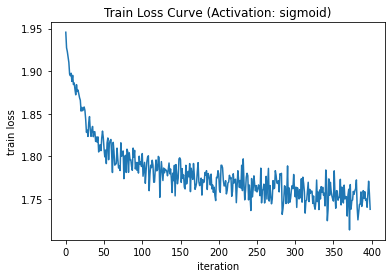

train accuracy: 0.4268166804293972
test accuracy: 0.37575476079888526
convergence time: 7.421607494354248
--------------------------------------------------------------------------------
activation function: <built-in method tanh of type object at 0x2b2c94182900>


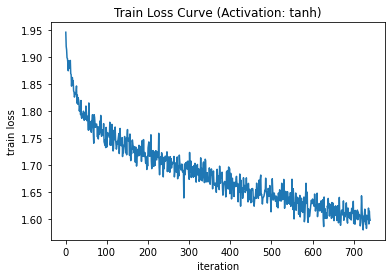

train accuracy: 0.6017237819983484
test accuracy: 0.40625483821024927
convergence time: 13.731104135513306
--------------------------------------------------------------------------------
activation function: <function relu at 0x2b2cd94bae18>


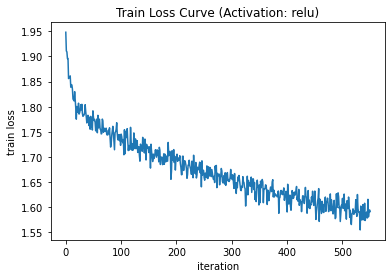

train accuracy: 0.6104459124690339
test accuracy: 0.4153893791608608
convergence time: 10.386274337768555
--------------------------------------------------------------------------------
activation function: <function leaky_relu at 0x2b2cd94be620>


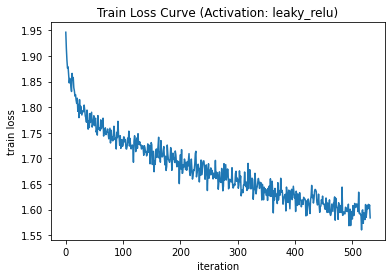

train accuracy: 0.6197873658133773
test accuracy: 0.4204985291840842
convergence time: 9.960151433944702


In [34]:
trials = [('sigmoid',torch.sigmoid), ('tanh',torch.tanh), ('relu',F.relu), ('leaky_relu',F.leaky_relu)]
for name, activ in trials:
    print('-'*80)
    print('activation function:', activ)
    net = NN(activ=activ).to(device)
    opt = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-3)
    loader = data.DataLoader(train_set, 1024, shuffle=True)
    tic = time.time()
    losses = train(net, opt, loader, eps=1e-8)
    toc = time.time()
    plt.plot(losses)
    plt.xlabel('iteration')
    plt.ylabel('train loss')
    plt.title(f'Train Loss Curve (Activation: {name})')
    plt.show()
    print('train accuracy:', accuracy_score(train_set.y.cpu(), net.predict(train_set.X).cpu()))
    print('test accuracy:', accuracy_score(test_set.y.cpu(), net.predict(test_set.X).cpu()))
    print('convergence time:', toc-tic)

In [267]:
class GaborDataset(data.Dataset):
    def __init__(self, X, y):
        G = np.empty(X.shape)
        for i in range(X.shape[0]):
            gabor_real, _ = gabor(X[i].reshape(48,48), frequency=0.75, theta=np.pi/4)
            G[i] = gabor_real.ravel()
        self.X = torch.cat((X, torch.FloatTensor(G)), dim=-1)
        self.y = y
    
    def to(self, device):
        self.X = self.X.to(device)
        self.y = self.y.to(device)
        return self
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [268]:
train_set_g = GaborDataset(train_set.X.cpu(), train_set.y.cpu()).to(device)

In [269]:
test_set_g = GaborDataset(test_set.X.cpu(), test_set.y.cpu()).to(device)

--------------------------------------------------------------------------------
activation function: <function leaky_relu at 0x2b2cd94be620>


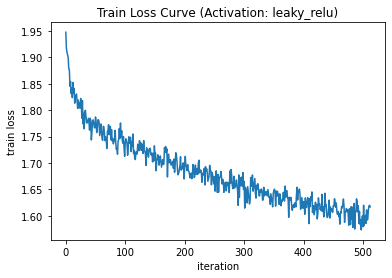

train accuracy: 0.5938790255986788
test accuracy: 0.4090416473138257
convergence time: 11.016495943069458


In [270]:
name, activ = 'leaky_relu', F.leaky_relu
print('-'*80)
print('activation function:', activ)
net = NN(activ=activ, input_dim=train_set_g.X.shape[1]).to(device)
opt = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-3)
loader = data.DataLoader(train_set_g, 1024, shuffle=True)
tic = time.time()
losses = train(net, opt, loader, eps=1e-8)
toc = time.time()
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('train loss')
plt.title(f'Train Loss Curve (Activation: {name})')
plt.show()
print('train accuracy:', accuracy_score(train_set_g.y.cpu(), net.predict(train_set_g.X).cpu()))
print('test accuracy:', accuracy_score(test_set_g.y.cpu(), net.predict(test_set_g.X).cpu()))
print('convergence time:', toc-tic)

In [271]:
class HOGDataset(data.Dataset):
    def __init__(self, X, y):
        h = hog(X[0].reshape(48,48), orientations=4, pixels_per_cell=(4,4))
        H = np.empty((X.shape[0], len(h)))
        H[0] = h
        for i in range(1, X.shape[0]):
            H[i] = hog(X[i].reshape(48,48), orientations=4, pixels_per_cell=(4,4))
        self.X = torch.cat((X, torch.FloatTensor(H)), dim=-1)
        self.y = y
    
    def to(self, device):
        self.X = self.X.to(device)
        self.y = self.y.to(device)
        return self
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [272]:
train_set_h = HOGDataset(train_set.X.cpu(), train_set.y.cpu()).to(device)

In [273]:
test_set_h = HOGDataset(test_set.X.cpu(), test_set.y.cpu()).to(device)

--------------------------------------------------------------------------------
activation function: <function leaky_relu at 0x2b2cd94be620>


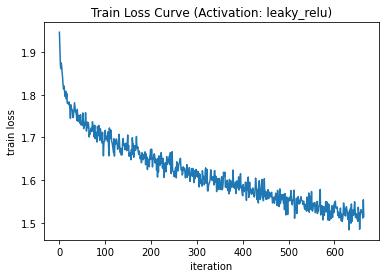

train accuracy: 0.6863645747316267
test accuracy: 0.454249883882954
convergence time: 14.669715166091919


In [274]:
name, activ = 'leaky_relu', F.leaky_relu
print('-'*80)
print('activation function:', activ)
net = NN(activ=activ, input_dim=train_set_h.X.shape[1]).to(device)
opt = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-3)
loader = data.DataLoader(train_set_h, 1024, shuffle=True)
tic = time.time()
losses = train(net, opt, loader, eps=1e-8)
toc = time.time()
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('train loss')
plt.title(f'Train Loss Curve (Activation: {name})')
plt.show()
print('train accuracy:', accuracy_score(train_set_h.y.cpu(), net.predict(train_set_h.X).cpu()))
print('test accuracy:', accuracy_score(test_set_h.y.cpu(), net.predict(test_set_h.X).cpu()))
print('convergence time:', toc-tic)

In [287]:
class GHDataset(data.Dataset):
    def __init__(self, X, y):
        G = np.empty(X.shape)
        for i in range(X.shape[0]):
            gabor_real, _ = gabor(X[i].reshape(48,48), frequency=0.75, theta=np.pi/4)
            G[i] = gabor_real.ravel()
        h = hog(X[0].reshape(48,48), orientations=4, pixels_per_cell=(4,4))
        H = np.empty((X.shape[0], len(h)))
        H[0] = h
        for i in range(1, X.shape[0]):
            H[i] = hog(X[i].reshape(48,48), orientations=4, pixels_per_cell=(4,4))
        self.X = torch.cat((X, torch.from_numpy(G).float(), torch.from_numpy(H).float()), dim=-1)
        self.y = y
    
    def to(self, device):
        self.X = self.X.to(device)
        self.y = self.y.to(device)
        return self
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [288]:
train_set_gh = GHDataset(train_set.X.cpu(), train_set.y.cpu()).to(device)

In [289]:
test_set_gh = GHDataset(test_set.X.cpu(), test_set.y.cpu()).to(device)

--------------------------------------------------------------------------------
activation function: <function leaky_relu at 0x2b2cd94be620>


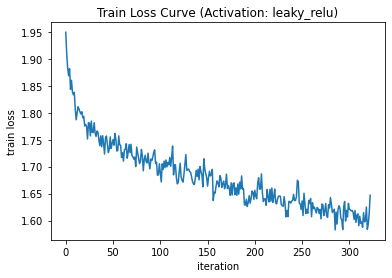

train accuracy: 0.5741639141205616
test accuracy: 0.4336584610620839
convergence time: 7.326792001724243


In [290]:
name, activ = 'leaky_relu', F.leaky_relu
print('-'*80)
print('activation function:', activ)
net = NN(activ=activ, input_dim=train_set_gh.X.shape[1]).to(device)
opt = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-3)
loader = data.DataLoader(train_set_gh, 1024, shuffle=True)
tic = time.time()
losses = train(net, opt, loader, eps=1e-8)
toc = time.time()
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('train loss')
plt.title(f'Train Loss Curve (Activation: {name})')
plt.show()
print('train accuracy:', accuracy_score(train_set_gh.y.cpu(), net.predict(train_set_gh.X).cpu()))
print('test accuracy:', accuracy_score(test_set_gh.y.cpu(), net.predict(test_set_gh.X).cpu()))
print('convergence time:', toc-tic)

In [327]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=3, padding=0)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2, padding=0)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(in_features=512, out_features=256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(in_features=256, out_features=7)
        self.softmax = nn.Softmax(dim=1)
        
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def criterion(self, y, yhat):
        return self.cross_entropy(yhat, y)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = self.bn3(x)
        
        x = self.softmax(self.fc2(x))
        
        return x
    
    def predict(self, X):
        self.eval()
        return torch.argmax(self(X), dim=-1)

In [328]:
class ConvFaceDataset(data.Dataset):
    def __init__(self, path):
        data = torch.tensor(pd.read_csv(path, header=None).values)
        y, X = data[:,0], data[:,1:]
        y = y.squeeze()
        self.X = X.float().reshape(-1,1,48,48)
        self.y = y.long()
    
    def to(self, device):
        self.X = self.X.to(device)
        self.y = self.y.to(device)
        return self
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [300]:
train_set_c = ConvFaceDataset('train.csv').to(device)

In [301]:
test_set_c = ConvFaceDataset('test.csv').to(device)

--------------------------------------------------------------------------------
activation function: <function leaky_relu at 0x2b2cd94be620>


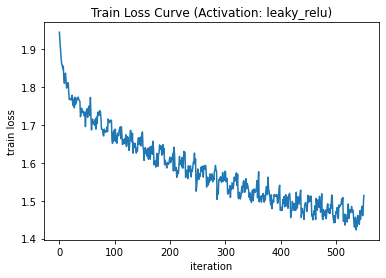

train accuracy: 0.7241948802642444
test accuracy: 0.4209629973680136
convergence time: 18.535422801971436


In [329]:
name, activ = 'leaky_relu', F.leaky_relu
print('-'*80)
print('activation function:', activ)
net = ConvNet().to(device)
opt = optim.Adam(net.parameters(), lr=5e-3, weight_decay=1e-3)
loader = data.DataLoader(train_set_c, 1024, shuffle=True)
tic = time.time()
losses = train(net, opt, loader, eps=1e-8)
toc = time.time()
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('train loss')
plt.title(f'Train Loss Curve (Activation: {name})')
plt.show()
print('train accuracy:', accuracy_score(train_set_c.y.cpu(), net.predict(train_set_c.X).cpu()))
print('test accuracy:', accuracy_score(test_set_c.y.cpu(), net.predict(test_set_c.X).cpu()))
print('convergence time:', toc-tic)

In [330]:
tic = time.time()
pred = net.predict(test_set_c.X)
toc = time.time()
print('inference time:', toc-tic)

inference time: 0.0019953250885009766


In [313]:
trainable_params(net)

167559

In [314]:
total_params(net)

167559

In [315]:
f1_score(test_set_c.y.cpu(), pred.cpu(), average='macro')

0.34870921798498067

--------------------------------------------------------------------------------
activation function: <function leaky_relu at 0x2b2cd94be620>


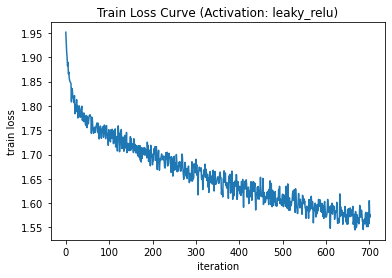

train accuracy: 0.6230388109000826
test accuracy: 0.41244774732930795
convergence time: 14.426973104476929


In [316]:
name, activ = 'leaky_relu', F.leaky_relu
print('-'*80)
print('activation function:', activ)
nnet = NN(activ=activ).to(device)
opt = optim.Adam(nnet.parameters(), lr=1e-3, weight_decay=1e-3)
loader = data.DataLoader(train_set, 1024, shuffle=True)
tic = time.time()
losses = train(nnet, opt, loader, eps=1e-8)
toc = time.time()
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('train loss')
plt.title(f'Train Loss Curve (Activation: {name})')
plt.show()
print('train accuracy:', accuracy_score(train_set.y.cpu(), nnet.predict(train_set.X).cpu()))
print('test accuracy:', accuracy_score(test_set.y.cpu(), nnet.predict(test_set.X).cpu()))
print('convergence time:', toc-tic)

In [317]:
trainable_params(nnet)

231207

In [318]:
total_params(nnet)

231207

In [319]:
tic = time.time()
pred = nnet.predict(test_set.X)
toc = time.time()
print('inference time:', toc-tic)

inference time: 0.0011439323425292969


In [320]:
f1_score(test_set.y.cpu(), pred.cpu(), average='macro')

0.33188236664859805

In [331]:
out = np.genfromtxt('output.txt')

In [332]:
out.shape

(6459,)

In [333]:
out

array([3., 2., 4., ..., 2., 4., 0.])

In [335]:
accuracy_score(test_set.y.cpu(), out)

0.4443412292924601

In [336]:
f1_score(test_set.y.cpu(), out, average='macro')

0.35170380399494133